# 集成计算 case 3: 芯部输运

## 介绍
__FyTok__ 用于执行集成计算。 

In [1]:
import numpy as np
from spdm.core.path import Path
from spdm.core.function import Function
from spdm.view import  sp_view

## 导入基准数据 （ITER 15MA）

In [2]:
from fytok.contexts.tokamak import Tokamak
from fytok.modules.core_profiles import CoreProfiles
from fytok.modules.equilibrium import Equilibrium

2024-07-22 07:13:15,739 [   fytok]  VERBOSE: Using ontology: imas/3 (dummy) at fytok/mappings/{schema}/imas/3:spdm/mapping/{schema}/imas/3


In [3]:
core_profiles_astra = CoreProfiles(f"file+iterprofiles:///home/salmon/workspace/fytok_tutorial/quick_start/data/15MA Inductive at burn-ASTRA.xls#core_profiles")

core_profiles_1d_astra = core_profiles_astra.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://./data/geqdsk.txt#equilibrium")

2024-07-22 07:13:16,176 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_iterprofiles
2024-07-22 07:13:16,298 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-07-22 07:13:16,300 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk


## 创建 Tokamak 实例

创建参数

| 参数                               | 解释                                                                                                                                                                                                |
| ---------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| "f""                | 数据源。指向一个 geqdsk 文件(file+geqdsk://...)，提供平衡信息,或者数据源的entry入口                                                                                                                                                          |
| device="name"                      | 指定装置名称。根据装置名称，可以自动调取装置的静态信息，例如，wall.limiter 的几何形状，pf_active.coils 极向场线圈的位置等等。默认支持的装置信息，括 EAST、ITER 和 D3D，可通过配置文件扩展其他装置。 |
| shot=900003 ，                     | 指定放电的炮号。若数据源包含实验数据库，会自动读取相应的炮号作为数据。                                                                                                                              |
| run=0                              | 指定模拟运行的编号。若数据源中包含可写入的是模拟数据库，写入模拟结果是会作为数据 index 的一部分。                                                                                                   |
| equilibrium={"code.name: "fy_eq" } | 指定子模块 equilibrium 的初始化信息。其中 code.name="fy_eq"，意为调用路径 `fytok.modules.equilibrium.fy_eq` 下的插件                                                                                |
| transport_solver={"code.name: "fy_trans" } | 指定子模块 transport_solver 的初始化信息。其中 code.name="fy_trans"，意为调用路径 `fytok.modules.equilibrium.fy_trans` 下的插件                                                                                |
| core_sources={"code.name: "genray" } | 指定子模块 core_sources 的初始化信息。其中 code.name="genray"，意为调用第三方物理模块genray                                                                                |
| core_transport="model": [ {"code": {"name": "dummy"}},,] | 指定子模块 core_transport 的初始化信息。其中 code.name意在调用计算输运系数的模块                                                                              |
| ...... | ......   |



In [4]:
tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium=f"file+geqdsk://./data/geqdsk.txt#equilibrium",
    core_transport=[
        {"code": {"name": "predefined"}},
        {"code": {"name": "fast_alpha"}},
    ],
    core_sources=[
        # f"file+iterprofiles://./data/profiles.xls#core_sources/source/0",
        {"code": {"name": "collisional_equipartition"}},
        {
            "code": {
                "name": "fusion",
                "parameters": {
                    "fusion_reactions": ["D(t,n)alpha"],
                    "heating": True,
                },
            }
        },
        # {"code": {"name": "radiation"}},
        # {"code": {"name": "synchrotron_radiation"}},
    ],
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "discontinuity": [0.96, 0.995],
                "dc_pos": 0.96,
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "psi_norm": 1,
                    "psi_norm_flux": -0.1,
                    "*/density": 1.0e19,
                    "*/density_flux": 1.0e23,
                    "*/temperature": 1.0e4,
                    "*/temperature_flux": 1.0e26,
                    # "ion/alpha/density": 1.0e14,
                    # "ion/alpha/density_flux": 1.0e16,
                    # "ion/He/density": 1.0e15,
                    # "ion/He/density_flux": 1.0e15,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        "ion_non_thermal": ["alpha", "He"],
        "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            "psi_norm"                  : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

2024-07-22 07:13:16,444 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_xml


In [5]:
print(tokamak)

2024-07-22 07:13:16,475 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_sources.source.collisional_equipartition
2024-07-22 07:13:16,478 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_sources.source.fusion
2024-07-22 07:13:16,531 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_transport.model.predefined
2024-07-22 07:13:16,533 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_transport.model.fast_alpha
2024-07-22 07:13:16,832 [   fytok]  VERBOSE: Load module fytok.plugins.modules.transport_solver.fy_trans
------------------------------------------------------------------------------------------------------------------------
    Device: ITER, Shot: 900003, Run: 0,
    Run by Salmon on Salmon at 2024-07-22T07:13:16.468364, base on ontology "modified imas/3" 
------------------------------------------------------------------------------------------------------------------------
- Context           : fy_tok-0.5.1 
- Actors            :
    cor

2024-07-22 07:13:16,856 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib


2024-07-22 07:13:16,957 [   fytok]  VERBOSE: Load module spdm.domain.mesh_rectangular


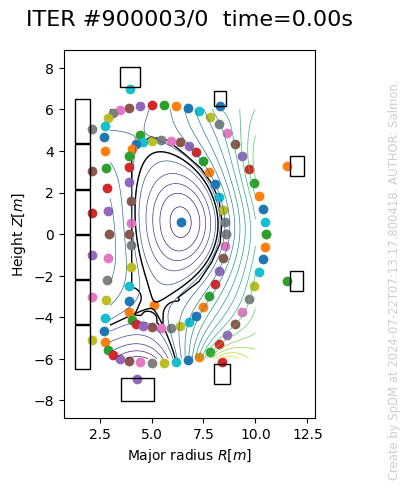

In [6]:
fig=sp_view.display(tokamak)

## 运行 Tokamak 实例

In [7]:
tokamak.initialize()

In [8]:
tokamak.refresh()

In [9]:
rho_tor_norm_bdry = 0.995
rho_tor_norm = np.linspace(0.001, rho_tor_norm_bdry, 128)
eq_grid = tokamak.equilibrium.profiles_1d.grid.remesh(rho_tor_norm)
psi_norm = eq_grid.psi_norm
F = (1 - rho_tor_norm**2) ** 2
n = 3e19 - tokamak.core_sources[0].fetch(core_profiles_1d_astra).profiles_1d.ion[
    "D"
].particles.I(rho_tor_norm)

TypeError: Illegal type! <fytok.modules.core_profiles.CoreProfiles1D object at 0x7fd101e49250>

In [ ]:
solver_1d = tokamak.solve(

    rho_tor_norm=rho_tor_norm,
    impurity_fraction=0.02 * 4 + 0.0012 * 18,
    # fmt:off
    initial_value={
        "psi":                              0.0,
        "psi_norm":                         psi_norm,
        "ion/D/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["D"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/T/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["T"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/He/density":                   2.0e19*F,   # core_profiles_1d_astra.ion["He"].density(rho_tor_norm)   ,#    
        "ion/alpha/density":                1.0e18*F,   #core_profiles_1d_astra.ion["alpha"].density(rho_tor_norm) ,# 
        
        "ion/D/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["D"].temperature(rho_tor_norm) *0.5,# 
        "ion/T/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["T"].temperature(rho_tor_norm) *0.5,# 
        "electrons/temperature":            3.5e4*F, #core_profiles_1d_astra.electrons.temperature(rho_tor_norm),# 
    },
    # boundary_value={
    #     "ion/D/density":                    n[-1],   # core_profiles_1d_astra.ion["D"].density (rho_tor_norm[-1])    ,
    #     "ion/T/density":                    n[-1],   # core_profiles_1d_astra.ion["T"].density (rho_tor_norm[-1])    ,
    #     "ion/He/density":                   1.0e19*F[-1],
    #     "ion/alpha/density":                1.0e18*F[-1],
    #     "ion/D/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["D"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "ion/T/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["T"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "electrons/temperature":            4.0e4*F[-1] , # core_profiles_1d_astra.electrons.temperature(rho_tor_norm[-1]),   # 2000,
    # },
    # fmt:on
)

## 后处理


In [ ]:
core_profiles_1d = tokamak.core_profiles.profiles_1d

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi_norm, r"$\bar{\psi}$"),
        (
            Function(
                equilibrium_astra.profiles_1d.grid.rho_tor_norm[:-1],
                equilibrium_astra.profiles_1d.grid.psi_norm[:-1],
            ),
            {"label": r"$\bar{\psi}$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi_norm"
    ],
    (
        (0.5 * (solver_1d.X[:-1] + solver_1d.X[1:]), solver_1d.rms_residuals * 100),
        {"label": "$rms$ residuals", "y_label": r"[\%]"},
    ),
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)